In [1]:
from PIL import Image
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
import geopandas as gpd

In [2]:
def create_grid(cell_size, total_depth, total_width, start_x, start_y):
    """
    Here, start_x and start_y should be the edge of the grid cell, not the centre
    """
    top_left_grid=[]
    for i in range(int(total_depth/ cell_size)):
        for j in range(int(total_width/ cell_size)):
            top_left_grid.append([start_x+j*cell_size, 
                                     start_y-i*cell_size])
    cells=[]
    for i in range(len(top_left_grid)):
        coords=[top_left_grid[i], 
                [top_left_grid[i][0]+cell_size, top_left_grid[i][1]], 
                [top_left_grid[i][0]+cell_size, top_left_grid[i][1]-cell_size], 
                [top_left_grid[i][0], top_left_grid[i][1]-cell_size],
                top_left_grid[i]]
        cell_poly=Polygon(coords)
        cells.append(cell_poly)
    cells_gdf=gpd.GeoDataFrame(geometry=cells)
    cells_gdf['cell_id']=list(range(len(cells_gdf)))
    centroids=cells_gdf.centroid
    cells_gdf['x']=[c.x for c in centroids]
    cells_gdf['y']=[c.y for c in centroids]
    return cells_gdf

In [3]:
blocks=pd.read_csv('blocks_4_128.csv')

In [4]:
# im =Image.open("images_4_128/0_250251006031021.png")
im =Image.open("model_230315/samples/0669.png")

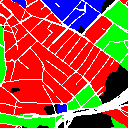

In [5]:
im=im.crop(box=[128, 0, 256, 128])
im

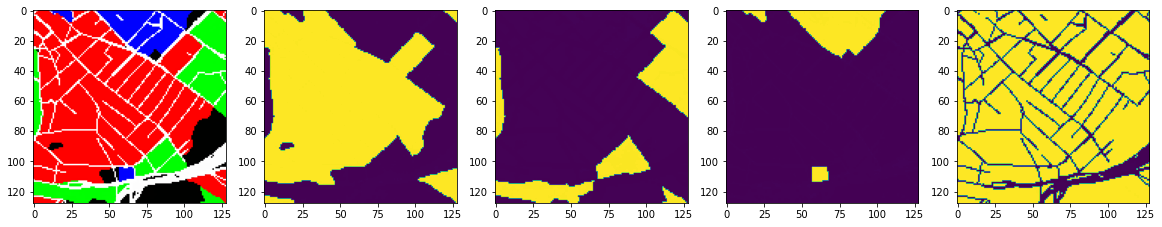

In [6]:
fig, axes=plt.subplots(1, 5, figsize=(20, 4))
axes[0].imshow(im)
for i in range(4):
    tmp=axes[i+1].imshow(im.getchannel(i))

In [7]:
resi_arr=im.getchannel(0).__array__()
comm_arr=im.getchannel(1).__array__()
retail_hosp_arr=im.getchannel(2).__array__()
road_arr=im.getchannel(3).__array__()

In [8]:
def discretize_arr(arr, cutoff=175, low_val=0, high_val=255):
    arr[arr<cutoff]=low_val
    arr[arr>=cutoff]=high_val
    return arr

In [9]:
resi_arr=discretize_arr(resi_arr)
comm_arr=discretize_arr(comm_arr)
retail_hosp_arr=discretize_arr(retail_hosp_arr)
road_arr=discretize_arr(road_arr)

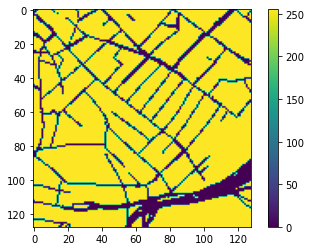

In [10]:
plt.imshow(road_arr)
plt.colorbar()

In [11]:
def fill_gaps(arr, node_val=0):
    original=arr.copy()
    nrows=arr.shape[0]
    ncols=arr.shape[1]
    for i in range(1, nrows-1):
        for j in range(1, ncols-1): 
            if not original[i, j] ==node_val:
                # if the cell above OR below is active
                if ((original[i+1, j] ==node_val) or (original[i-1, j] ==node_val)):
                    # and the cell to the right or left is active
                    if ((original[i, j+1] ==node_val) or ((original[i, j-1] ==node_val))):
                        arr[i, j] =node_val            
    return arr

In [12]:
print((road_arr==0).sum())
for i in range(1):
    road_arr=fill_gaps(road_arr.copy(), node_val=0)
    print((road_arr==0).sum())

2776
4435


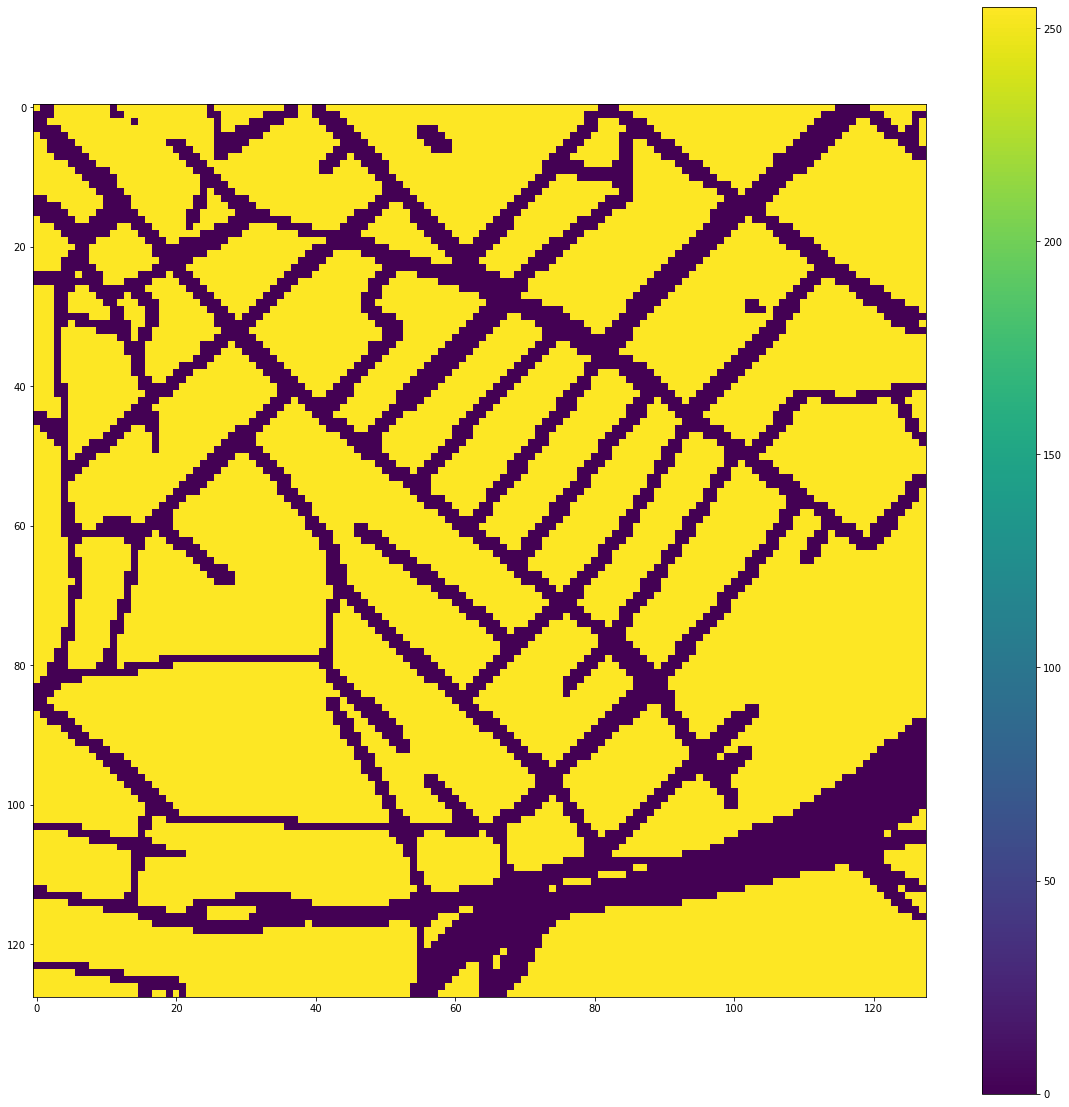

In [13]:
plt.figure(figsize=(20,20))
plt.imshow(road_arr)
plt.colorbar()

In [14]:
road_mask=(road_arr==255).astype(int)

Use the road array to mask the other arrays to create parcels

In [15]:
resi_arr=np.multiply(resi_arr, road_mask)
comm_arr=np.multiply(comm_arr, road_mask)
retail_hosp_arr=np.multiply(retail_hosp_arr, road_mask)

In [16]:
start_x, start_y = blocks.loc[0, ['grid_start_x', 'grid_start_y']].values

In [17]:
grid_gdf=create_grid(cell_size=8, total_depth=8*128, total_width=8*128, 
                     start_x=start_x, start_y=start_y)


In [18]:
cell_to_xy=grid_gdf[['x', 'y']].to_dict(orient='index')

In [19]:
# grid_gdf.explore(tooltip=['cell_id'])

In [20]:
def create_graph(arr, node_val=255, diag=False):
    # for a single color channel (lu type or road)
    # iterate through rows and cols
    # for each pixel, if active, check to right, below (and diag for road)
    # if both active, create a link
    G=nx.Graph()
    nrows=arr.shape[0]
    ncols=arr.shape[1]
    for i in range(nrows-1):
        for j in range(ncols-1):
            if arr[i, j]==node_val:
                if arr[i+1, j]==node_val:
                    G.add_edge(i*ncols+j, (i+1)*ncols+j)
                if arr[i, j+1]==node_val:
                    G.add_edge(i*ncols+j, i*ncols+j+1)
                if (diag and (arr[i+1, j+1]==node_val)):
                    G.add_edge(i*ncols+j, (i+1)*ncols+j+1)
    return G

def diag_length(side_length):
    return (side_length**2 + side_length**2)**(1/2)

def road_graph_df(arr, cell_to_xy, cell_size, node_val=0, diag=False):
    edges=[]
    nrows=arr.shape[0]
    ncols=arr.shape[1]
    for i in range(nrows-1):
        for j in range(ncols-1):
            if arr[i, j]==node_val:
                if arr[i+1, j]==node_val:
                    edges.append({'from': i*ncols+j, 'to': (i+1)*ncols+j, 'dist': cell_size})
                    edges.append({'to': i*ncols+j, 'from': (i+1)*ncols+j, 'dist': cell_size})
                if arr[i, j+1]==node_val:
                    edges.append({'from': i*ncols+j, 'to': i*ncols+j+1, 'dist': cell_size})
                    edges.append({'to': i*ncols+j, 'from': i*ncols+j+1, 'dist': cell_size})
                if (diag and (arr[i+1, j+1]==node_val)):
                    edges.append({'from': i*ncols+j, 'to': (i+1)*ncols+j+1, 
                                          'dist': diag_length(cell_size)})
                    edges.append({'to': i*ncols+j, 'from': (i+1)*ncols+j+1, 
                                          'dist': diag_length(cell_size)})
    edges_df=pd.DataFrame(edges)
    edges_df['travel_time']=edges_df['dist']/(4.8/3.6) # walking speed in m/s
    
    valid_nodes=list(pd.concat([edges_df['from'], edges_df['to']]).unique())
    nodes={k: cell_to_xy[k] for k in valid_nodes}
    nodes_df=pd.DataFrame.from_dict(nodes, orient='index')
    return nodes_df, edges_df
            
    
def create_geometries(G, grid_gdf):
    components=[c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    for i, c in enumerate(components):
        grid_gdf.loc[list(c), 'component']='c'+str(i)
    parcels=grid_gdf.loc[~grid_gdf['component'].isnull()].dissolve(by='component')
    return parcels

In [21]:
# grid_gdf.explore(tooltip='cell_id')

In [23]:
G_resi=create_graph(resi_arr, node_val=255, diag=False)
parcels_resi=create_geometries(G_resi, grid_gdf.copy())
parcels_resi['lu']='Resi'

G_comm=create_graph(comm_arr, node_val=255, diag=False)
parcels_comm=create_geometries(G_comm, grid_gdf.copy())
parcels_comm['lu']='Comm'

G_retail_hosp=create_graph(retail_hosp_arr, node_val=255, diag=False)
parcels_retail_hosp=create_geometries(G_retail_hosp, grid_gdf.copy())
parcels_retail_hosp['lu']='Ret_Hosp'

all_parcels=pd.concat([parcels_resi, parcels_comm, parcels_retail_hosp])

<AxesSubplot:>

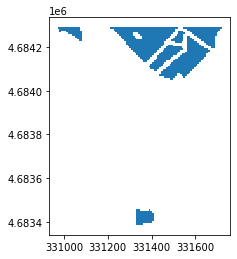

In [24]:
parcels_retail_hosp.plot()

In [25]:
all_parcels.explore(column='lu')

# Create Pandana

In [26]:
nodes_df, edges_df=road_graph_df(road_arr, cell_to_xy, cell_size=8,  node_val=0, diag=False)

Check connectivity with networkx

In [27]:
G=nx.Graph()
for ind, row in edges_df.iterrows():
    G.add_edge(row['from'], row['to'])
#     components=[c for c in sorted(nx.connected_components(G), key=len, reverse=True)]

In [28]:
components=[c for c in sorted(nx.connected_components(G), key=len, reverse=True)]

In [29]:
nodes_df['component']=0
for i, c in enumerate(components):
    nodes_df.loc[list(c), 'component']='c'+str(i)

In [30]:
nodes_df.groupby('component').size().sort_values(ascending=False)

component
c0    4335
c1      40
c2      36
c3      14
c4       5
c5       3
dtype: int64

In [31]:
nodes_df['z']=0

In [32]:
utm_zone = 19
utm_crs = f"+proj=utm +zone={utm_zone} +ellps=WGS84 +datum=WGS84 +units=m +no_defs"

nodes_gdf=gpd.GeoDataFrame(data=nodes_df, geometry=gpd.points_from_xy(
    nodes_df['x'], nodes_df['y']), crs=utm_crs)

In [33]:
nodes_gdf.explore(column='component')

In [34]:
import pandana as pdna

In [35]:
net=pdna.network.Network(nodes_df['x'], nodes_df['y'], 
                            edges_df['from'], edges_df['to'], 
                            edge_weights=edges_df[['travel_time']], twoway=True)

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 4433
Setting CH edge vector of size 13346
Range graph removed 13346 edges of 26692
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


# Convert to lat lon for visualization

In [36]:
all_parcels['node']=net.get_node_ids(all_parcels['x'], all_parcels['y'])

In [37]:
all_parcels.crs=utm_crs
all_parcels_wgs=all_parcels.to_crs('epsg:4326')

nodes_gdf_wgs=nodes_gdf.to_crs('epsg:4326')
nodes_gdf_wgs['lon']=nodes_gdf_wgs.geometry.x
nodes_gdf_wgs['lat']=nodes_gdf_wgs.geometry.y
node_id_to_coords={ind: [row['lon'], row['lat'], row['z']] for ind, row in nodes_gdf_wgs.iterrows()}

edges_df=edges_df.set_index(['from', 'to'], drop=False)
edge_attr_lookup=edges_df[['travel_time']].to_dict(orient='index')

In [38]:
all_parcels_wgs.explore()

In [39]:
import random
def get_trip(path, node_id_to_coords, attr_lookup, profile,
             travel_time_col='travel_time', 
             trip_start_time=0, time_window=500):
    weights= []
    types=[]
    for i in range(len(path)-1):
        weights.append(attr_lookup[(path[i], path[i+1])][travel_time_col])
#         types.append(attr_lookup[(path[i], path[i+1])]['type'])
    
    st= trip_start_time + random.randint(1, time_window)
    times=[st]+list(st+ np.cumsum(weights))
    times=[int(t) for t in times]
    coords=[node_id_to_coords[n] for n in path]
    return {'path': coords, 'timestamps': times, 
#             'edge_types':types, 
            'profile': profile
           }

In [40]:
N=100
prof='commuter'

source_nodes=all_parcels.loc[all_parcels['lu']=='Resi', 'node'].sample(100, replace=True)
target_nodes=all_parcels.loc[all_parcels['lu']=='Comm', 'node'].sample(100, replace=True)

paths=net.shortest_paths(list(source_nodes), 
                         list(target_nodes), 
                         imp_name='travel_time')
trips=[get_trip(p, node_id_to_coords, edge_attr_lookup, prof,'travel_time', 
          trip_start_time=7*3600) for p in paths]

In [41]:
import json
with open('deck_gl/data/trips.json', 'w') as f:
    json.dump(trips,f)

In [42]:
all_parcels_wgs.to_file('deck_gl/data/parcels.geojson')

In [43]:
all_parcels_wgs['lu'].unique()

array(['Resi', 'Comm', 'Ret_Hosp'], dtype=object)